## MNIST Handwritten digits classifier

In [1]:
# Import the goodies
%matplotlib inline
%load_ext tensorboard

import numpy as np
import time
import tensorflow as tf
from tensorflow import keras  # import from tensorflow for better support??? I dunno
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

In [2]:
# Load the data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
# Reshape the data
X = x_train.reshape(60000, 28, 28, 1)
y = y_train.reshape(60000, 1)

# Process the data
X = X / 255.0

# Onehot encode y_train
enc = OneHotEncoder().fit(y)
y = enc.transform(y).toarray()

In [4]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

To find the most ambigious images in the test dataset, we must first build a classifier that gives us the probability of which digit it is

In [5]:
# Build the network

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)))  # Filter the data
model.add(layers.MaxPooling2D((2,2)))                                            # Make the view larger; find bigger patterns
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())                                                      # Dimension reduce
model.add(layers.Dropout(0.5))                                                   # Get rid of conspiracies
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='sigmoid'))

model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="loss"),  # Stop early if training is only going ok
    tf.keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True, monitor="loss"),
    tf.keras.callbacks.ProgbarLogger(),
#    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]


model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

2021-09-08 13:18:14.706399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

2021-09-08 13:18:14.713285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 13:18:14.713863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 13:18:14.715063: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-08 13:18:14.715667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [6]:
# Fit the network
tick = time.time()
history = model.fit(X, y,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=1)
#model.save('net1.h5')
print('Took',(time.time()-tick).__round__(4),'seconds to train the network')

2021-09-08 13:18:15.279519: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-08 13:18:16.003439: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2021-09-08 13:18:16.857462: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Took 33.4163 seconds to train the network


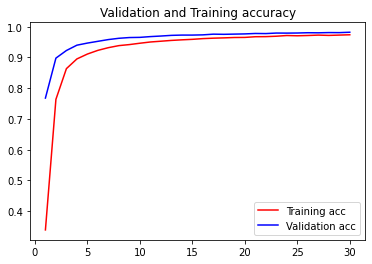

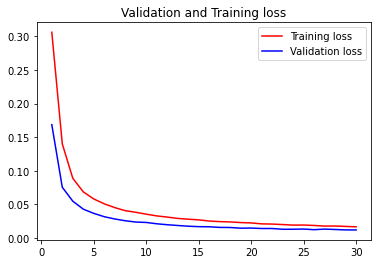

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Validation and Training accuracy')
plt.legend()

plt.figure()  # Combines the two graphs

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Validation and Training loss')
plt.legend()

plt.show()

In [49]:
# Test and see how well it classified the data
X_ = x_test.reshape(10000, 28, 28, 1)
y_ = enc.transform(y_test.reshape((10000,1))).toarray()

X_ = X_ / 255.0

preds = model.predict(X_)

In [50]:
model.evaluate(X_, y_)

313/313 [==============================] - 0s 1ms/step - loss: 0.0117 - acc: 0.9818


[0.011690223589539528, 0.9818000197410583]

The model ended up with 98% on the test set showing that it fit to the data very well. It can then provide us with valuable insight

In [35]:
# Find what the model's predictions actually were
summary = np.zeros((10,10))

for p, truth in zip(preds.copy(), y_test):
    p[truth] = 0  # Remove the correct result
    summary[truth] += p
    #print(p, truth)

row_sums = summary.sum(axis=1)
summary = summary / row_sums[:, np.newaxis]    

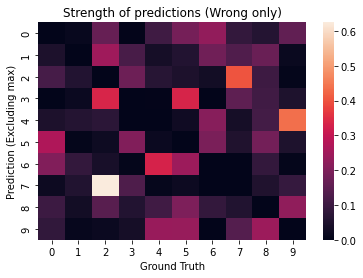

In [37]:
# Add a seaborn plot of 1-10 of classes on each row and how well it classified them
ax = plt.axes()
sns.heatmap(summary, ax=ax)
ax.set_title(f'Strength of predictions (Wrong only)')
plt.xlabel("Ground Truth")
plt.ylabel("Prediction (Excluding max)")
plt.show()

From this plot we can see that often the model predicts a 7 when the ground truth was 2. Likewise this is reflected in how it also predicts a 2 when the ground truth is a 7. However, while these seem significant these results are still excluding all the correct datapoints.

In [38]:
arr = np.vstack((np.arange(0,10000), y_test, preds.argmax(axis=1), np.max(preds, axis=1))).T
# Columns: Index, Truth, Guess, Confidence

In [79]:
# Find the 10 most worst classified datapoints (by its own estimation)
arr = arr[arr[:,3].argsort()]
arr

array([[2.75400000e+03, 6.00000000e+00, 6.00000000e+00, 1.31851077e-01],
       [2.83600000e+03, 4.00000000e+00, 4.00000000e+00, 1.93618953e-01],
       [9.63400000e+03, 0.00000000e+00, 1.00000000e+00, 2.06471324e-01],
       ...,
       [1.30600000e+03, 4.00000000e+00, 4.00000000e+00, 1.00000000e+00],
       [5.02800000e+03, 3.00000000e+00, 3.00000000e+00, 1.00000000e+00],
       [3.50000000e+03, 4.00000000e+00, 4.00000000e+00, 1.00000000e+00]])

Create a heatmap of these bad classifications

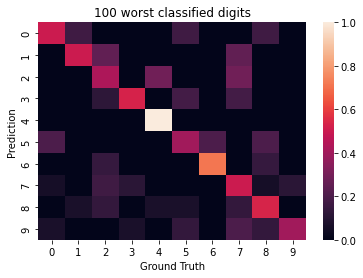

In [40]:
# Amount to show
n = 100
heat = np.zeros((10,10))

for i, truth, guess, con in arr[:n]:
    heat[int(truth), int(guess)] += 1

row_sums = heat.sum(axis=1)
heat = heat / row_sums[:, np.newaxis] 

ax = plt.axes()
sns.heatmap(heat, ax=ax)
ax.set_title(f'{n} worst classified digits')
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.show()

Least confident digits


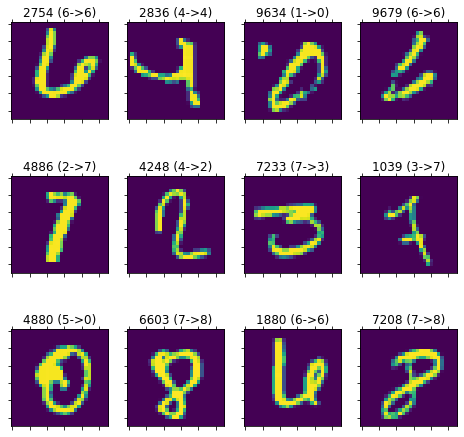

In [78]:
cols = 4
rows = 3
to_plot = arr[:, 0][:rows*cols].astype('int')
fig, axs = plt.subplots(rows, cols, figsize=(8, 8))

#fig.tight_layout()
cnt = 0
for i in range(rows):
    for j in range(cols):
        axs[i,j].matshow(x_test[to_plot[cnt]])
        axs[i, j].set_title(f'{to_plot[cnt]} ({int(arr[j+i*cols, 2])}->{int(arr[j+i*cols, 1])})')
        axs[i, j].xaxis.set_ticklabels([])
        axs[i, j].yaxis.set_ticklabels([])
        cnt += 1
print("Least confident digits")
plt.show()

Legend: `ID (GUESS -> TRUTH)`

Some of the least confidence ids:
- 2754 (Really bad 6)
- 2836 (Doesn't really look like a number)
- 4886 (1 or 2 or 7 ?)

Most confident incorrect digits


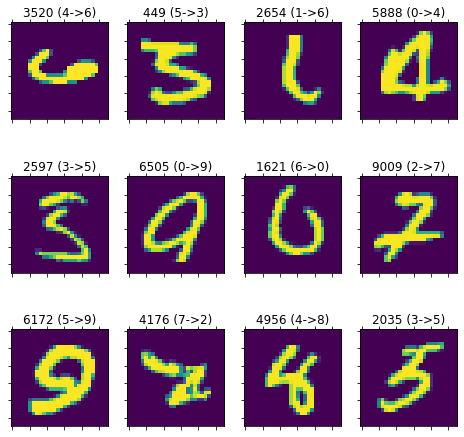

In [86]:
# Looking at all the digits that the classifier got wrong, which ones was it most confident about?
wrong = arr[arr[:,1] != arr[:,2]]
wrong = wrong[wrong[:,3].argsort()[::-1]]  # Set into descending order
cols = 4
rows = 3

to_plot = wrong[:, 0][:rows*cols].astype('int')
fig, axs = plt.subplots(rows, cols, figsize=(8, 8))

#fig.tight_layout()
cnt = 0
for i in range(rows):
    for j in range(cols):
        axs[i,j].matshow(x_test[to_plot[cnt]])
        axs[i, j].set_title(f'{to_plot[cnt]} ({int(wrong[j+i*cols, 2])}->{int(wrong[j+i*cols, 1])})')
        axs[i, j].xaxis.set_ticklabels([])
        axs[i, j].yaxis.set_ticklabels([])
        cnt += 1
print("Most confident incorrect digits")
plt.show()

These are the digits that the model was most confident about, but was wrong. Most of them are ambigious

Examples
- 4176 (Looks like a scribble)
- 2035 (Contains both elements from 3 and 5)
- 3520 (Looks like neither a 4 nor 6)
- 2654 (Appears to be a 1 not a 6)